In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from scipy.stats import pearsonr

In [2]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif, RFE
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, explained_variance_score, \
    roc_auc_score, roc_curve

## 1. Grow Up data

In [3]:
election_data = pd.read_csv('election_data.csv', dtype = {'fips_code': str})
election_data = election_data.rename(columns={'fips_code':'fips'})
print(election_data.shape)
print(election_data.head())

(3112, 20)
    fips              county  total_2008  dem_2008  gop_2008  oth_2008  \
0  26041        Delta County       19064      9974      8763       327   
1  48295     Lipscomb County        1256       155      1093         8   
2  01127       Walker County       28652      7420     20722       510   
3  48389       Reeves County        3077      1606      1445        26   
4  56017  Hot Springs County        2546       619      1834        93   

   total_2012  dem_2012  gop_2012  oth_2012  total_2016  dem_2016  gop_2016  \
0       18043      8330      9533       180       18467      6431     11112   
1        1168       119      1044         5        1322       135      1159   
2       28497      6551     21633       313       29243      4486     24208   
3        2867      1649      1185        33        3184      1659      1417   
4        2495       523      1894        78        2535       400      1939   

   oth_2016 2008_result  2008_dem_ratio  2012_dem_ratio  2016_dem_rat

## 2. Census data

In [4]:
census = pd.read_csv('data/cencus_preprocessed.csv', dtype = {'fips': str})
census_dictionary = pd.read_csv('data/dictionary.csv')

In [5]:
census.shape

(3220, 217)

In [6]:
census.head()

,fips,B15001002,B15001003,B15001004,B15001005,B15001006,B15001007,B15001008,B15001009,B15001010,...,B18101034,B18101035,B18101036,B18101037,B18101038,B18101039,B23020001,B23020002,B23020003,B01003001
0,01001,0.479953,0.061069,0.000169,0.005852,0.029234,0.017796,0.002528,0.004648,0.000843,...,0.047388,0.020214,0.027174,0.032084,0.019826,0.012258,0.655395,0.648120,0.705773,0.005446
1,01003,0.482436,0.049210,0.000341,0.010103,0.018786,0.013046,0.002539,0.004225,0.000170,...,0.060429,0.014119,0.046310,0.040895,0.018569,0.022326,0.636071,0.636090,0.675978,0.020123
2,01005,0.540146,0.062068,0.002755,0.017354,0.024992,0.015759,0.000870,0.000338,0.000000,...,0.063020,0.020063,0.042956,0.044071,0.032196,0.011875,0.619968,0.610526,0.666667,0.002593
3,01007,0.538819,0.060721,0.004873,0.012492,0.021846,0.019326,0.000392,0.001793,0.000000,...,0.046125,0.009585,0.036540,0.042086,0.022333,0.019754,0.645733,0.648120,0.670391,0.002234
4,01009,0.490250,0.055802,0.000295,0.010498,0.019342,0.016893,0.007551,0.001224,0.000000,...,0.056182,0.014544,0.041638,0.038212,0.017917,0.020295,0.658615,0.654135,0.700186,0.005706


## 3. Model

In [11]:
fips_class = election_data
fips_class['y'] = 0 ##adding one columns as 'y'
fips_class.loc[fips_class['2012_result']=='dem', 'y'] = 1 ## target
fips_class = fips_class[['fips', 'y']]

In [12]:
fips_class['y'].value_counts()

0    2426
1     686
Name: y, dtype: int64

In [13]:
X = census.merge(fips_class.loc[:, ['fips', 'y']]) ##loc
X = X.sample(X.shape[0], replace=False).reset_index(drop=True) ##Random choose sample and Reset the index of the DataFrame, and use the default one instead 
X = X.loc[~X.duplicated(), :].reset_index(drop=True) ## delete duplicated data
X = X.set_index('fips')
y = X['y']

In [14]:
X.head()

,B15001002,B15001003,B15001004,B15001005,B15001006,B15001007,B15001008,B15001009,B15001010,B15001011,...,B18101035,B18101036,B18101037,B18101038,B18101039,B23020001,B23020002,B23020003,B01003001,y
fips,,,,,,,,,,,,,,,,,,,,,
29217,0.474723,0.052528,0.004139,0.009742,0.016682,0.017318,0.003311,0.001337,0.000000,0.073093,...,0.014519,0.040387,0.037413,0.018930,0.018484,0.647343,0.654135,0.681564,0.002045,0
06073,0.500410,0.077232,0.001032,0.007171,0.028720,0.030940,0.003198,0.005851,0.000319,0.109096,...,0.008397,0.031590,0.033049,0.017438,0.015611,0.621578,0.615038,0.664804,0.324931,1
42071,0.482578,0.061569,0.004324,0.008534,0.024345,0.017373,0.002688,0.004110,0.000196,0.083807,...,0.008682,0.038235,0.042193,0.018593,0.023600,0.618357,0.634586,0.636872,0.053088,0
05145,0.482543,0.077467,0.000932,0.004310,0.020386,0.045282,0.001881,0.004676,0.000000,0.080929,...,0.015951,0.032248,0.036550,0.019139,0.017411,0.629630,0.642105,0.657356,0.007788,0
48083,0.507057,0.034148,0.002125,0.004857,0.008499,0.016694,0.000000,0.001973,0.000000,0.082562,...,0.009306,0.049630,0.049392,0.015390,0.034001,0.663446,0.682707,0.653631,0.000833,0


### 3.1 Checking z test 

In [16]:
audit = pd.DataFrame({'columns':[], 'ref_mean':[], 'ref_std':[], 
                      'tgt_mean':[], 'tgt_std':[], 'ratio':[], 'ztest':[]})
for i in range(0,X.shape[1]-1):
    col = X.columns[i]
    ref_cnt = X.loc[X['y']==0].shape[0]
    ref_mean = X.loc[X['y']==0, col].mean()
    ref_std = X.loc[X['y']==0, col].std()
    tgt_mean = X.loc[X['y']==1, col].mean()
    tgt_std = X.loc[X['y']==1, col].std()
    tgt_cnt = X.loc[X['y']==1].shape[0]
    ratio = tgt_mean/ref_mean
    sigma = np.sqrt(ref_std*tgt_std/ref_cnt + ref_std*tgt_std/tgt_cnt)
    ztest = np.abs(ref_mean-tgt_mean)/sigma
    audit = audit.append(pd.DataFrame({'columns':[col], 'ref_mean':[ref_mean], 'ref_std':[ref_std], 
                                       'tgt_mean':[tgt_mean], 'tgt_std':[tgt_std], 'ratio':[ratio], 
                                       'ztest':[ztest]}))

In [18]:
## sort variable with ascending ztest score
census_dictionary.merge(audit).sort_values('ztest', ascending=False).to_csv('audit_report_v1.csv', index=False)

In [19]:
X = X.loc[:, [c for c in X.columns if c not in ['y']]] ## get all independent variable
X.shape 

(3111, 216)

In [20]:
## randomly split dataset into trianing and testing data for CV
idx = np.arange(X.shape[0]) 
np.random.seed(1234)
train_idx = X.index[np.random.choice(idx, int(X.shape[0]/2), replace=False)]
test_idx = np.setdiff1d(X.index, train_idx) 
## Return the sorted, unique values in X.index that are not in train_idx

### 3.2 Building gradient boosting model

In [21]:
cross_val_score(GradientBoostingClassifier(), X, y, 
               scoring='roc_auc', cv=5, n_jobs=5)

array([0.92729266, 0.91471142, 0.91600572, 0.93417112, 0.93384002])

In [22]:
## Training gradient boosting model
class_model = GradientBoostingClassifier().fit(
    X.loc[train_idx,:], y[train_idx])

In [23]:
## Calculating accuracy of trained model in tesing dataset
class_true = y[test_idx]
class_prob = class_model.predict_proba(X.loc[test_idx, :])[:,1]
roc_auc_score(class_true, class_prob)

0.9187698907393447

### 3.3 Generating ROC Curve for CV

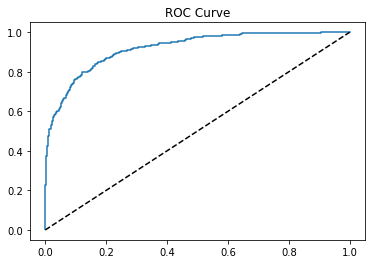

In [24]:
curve = roc_curve(class_true, class_prob)
plt.plot(curve[0], curve[1])
plt.title('ROC Curve')
plt.plot([0,1], [0,1], color='black', linestyle='--')

In [25]:
## finding variable importance
importance = pd.DataFrame(list(zip(X.columns, class_model.feature_importances_)),
             columns=('columns', 'class_importance'))
importance = importance.merge(census_dictionary)
importance = importance.merge(audit[['columns', 'ref_mean', 'tgt_mean', 'ratio', 'ztest']])

In [26]:
importance.sort_values('class_importance', ascending=False).head(10)

,columns,class_importance,description,table,ref_mean,tgt_mean,ratio,ztest
82,B02001002,0.081800,White alone,Race,0.871879,0.706954,0.810840,23.400780
94,B11001003,0.066580,Family households: Married-couple family,Household Type (Including Living Alone),0.526802,0.456461,0.866476,25.189718
212,B23020001,0.029039,Total:,Mean Usual Hours Worked in the Past 12 Months ...,0.637961,0.618238,0.969083,17.068993
100,B11001009,0.028856,Nonfamily households: Householder not living a...,Household Type (Including Living Alone),0.046897,0.063321,1.350222,15.325887
215,B01003001,0.025688,Total,Total Population,0.005721,0.026000,4.544321,15.372356
85,B02001005,0.025015,Asian alone,Race,0.008579,0.028091,3.274223,18.455568
75,B15001077,0.020577,Female: 65 years and over: Less than 9th grade,Sex by Age by Educational Attainment for the P...,0.010408,0.010809,1.038492,1.078230
97,B11001006,0.017569,Family households: Other family: Female househ...,Household Type (Including Living Alone),0.104375,0.136702,1.309712,16.855658
177,B18101005,0.017034,Male: Under 5 years: No disability,Sex by Age by Disability Status,0.030425,0.030218,0.993166,0.670233
205,B18101033,0.016789,Female: 35 to 64 years: No disability,Sex by Age by Disability Status,0.165359,0.170166,1.029068,6.086081


In [27]:
importance.loc[importance['table']=='Household Income in the Past 12 Months (In 2017 Inflation-adjusted Dollars)']

,columns,class_importance,description,table,ref_mean,tgt_mean,ratio,ztest
158,B19001002,0.004150,"Less than $10,000",Household Income in the Past 12 Months (In 201...,0.074694,0.085667,1.146910,6.533392
159,B19001003,0.000000,"$10,000 to $14,999",Household Income in the Past 12 Months (In 201...,0.060428,0.062023,1.026393,1.496217
160,B19001004,0.001652,"$15,000 to $19,999",Household Income in the Past 12 Months (In 201...,0.059863,0.057805,0.965628,2.278557
161,B19001005,0.004615,"$20,000 to $24,999",Household Income in the Past 12 Months (In 201...,0.060451,0.056493,0.934524,5.256075
162,B19001006,0.006218,"$25,000 to $29,999",Household Income in the Past 12 Months (In 201...,0.056972,0.052366,0.919149,7.119753
163,B19001007,0.013010,"$30,000 to $34,999",Household Income in the Past 12 Months (In 201...,0.057063,0.052045,0.912060,8.279653
164,B19001008,0.008867,"$35,000 to $39,999",Household Income in the Past 12 Months (In 201...,0.052003,0.047401,0.911505,8.452745
165,B19001009,0.001014,"$40,000 to $44,999",Household Income in the Past 12 Months (In 201...,0.051177,0.047153,0.921369,7.962935
166,B19001010,0.002687,"$45,000 to $49,999",Household Income in the Past 12 Months (In 201...,0.044719,0.040829,0.913005,8.602145
167,B19001011,0.000426,"$50,000 to $59,999",Household Income in the Past 12 Months (In 201...,0.084271,0.077647,0.921395,9.824904


In [35]:
importance.loc[importance['table']=='Race']

,columns,class_importance,description,table,ref_mean,tgt_mean,ratio,ztest
82,B02001002,0.081800,White alone,Race,0.871879,0.706954,0.810840,23.400780
83,B02001003,0.002898,Black or African American alone,Race,0.065698,0.180894,2.753404,17.752531
84,B02001004,0.007508,American Indian and Alaska Native alone,Race,0.013067,0.027989,2.141887,5.167852
85,B02001005,0.025015,Asian alone,Race,0.008579,0.028091,3.274223,18.455568
86,B02001006,0.006575,Native Hawaiian and Other Pacific Islander alone,Race,0.000648,0.001434,2.212791,4.741650
87,B02001007,0.005276,Some other race alone,Race,0.018335,0.028399,1.548876,5.768688
88,B02001008,0.009050,Two or more races:,Race,0.021793,0.026240,1.204052,5.245955
89,B02001009,0.001154,Two or more races: Two races including Some ot...,Race,0.002340,0.003435,1.467657,6.605908
90,B02001010,0.008323,Two or more races: Two races excluding Some ot...,Race,0.019452,0.022805,1.172337,4.174776


In [28]:
importance.sort_values('class_importance', ascending=False).to_csv('class_model_importance_v1.csv', index=False)

In [29]:
## Score all counties by using 2012 model
class_prob_all = pd.DataFrame({'fips': X.index, 'score':class_model.predict_proba(X)[:,1]})
class_prob_all.head()

,fips,score
0,29217,0.021994
1,06073,0.860215
2,42071,0.078582
3,05145,0.016290
4,48083,0.033582


## 4. Validate on 2016 election result

In [30]:
fips_class['y_val'] = 0
fips_class.loc[election_data['2016_result']=='dem', 'y_val'] = 1
fips_class_val = class_prob_all.merge(fips_class.loc[:, ['fips', 'y_val']])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [31]:
fips_class['y_val'].value_counts()

0    2625
1     487
Name: y_val, dtype: int64

In [32]:
roc_auc_score(fips_class_val['y_val'], fips_class_val['score']) ##compare actual result and predicted result from previous score

0.9727995296884187

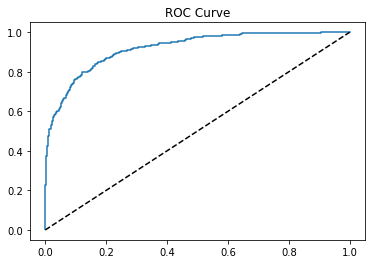

In [36]:
curve = roc_curve(class_true, class_prob)
plt.plot(curve[0], curve[1])
plt.title('ROC Curve')
plt.plot([0,1], [0,1], color='black', linestyle='--')